# Análise da satisfação e saídas de funcionários de uma empresa

**Contexto:**

O time de Recursos Humanos de uma empresa de tecnologia quer realizar ações de retenção de talentos e melhorias internas, pois acredita que fatores como nível salarial, departamento e tempo de casa possam influenciar a satisfação com a empresa e a saída de funcionários. Para essa análise, foram disponibilizados dados de satisfação dos funcionários, saídas da empresa, salário, cargo e tempo de permanência.

**Objetivos da análise:**

Os objetivos da análise são realizar as seguintes verificações para que possam ser detectados padrões relacionados à saída e satisfação com a empresa:
- Existe associação entre o nível salarial do funcionário e a intenção de sair da empresa?
- Algum departamento tem maior risco de perda de talentos?
- O padrão de satisfação difere entre quem ficou e quem saiu da empresa?
- A satisfação difere entre departamentos?
- O tempo de casa influencia a satisfação?

Para atingir os objetivos pretendidos, realizou-se uma análise exploratória de dados seguida de uma análise estatística. Com base nos resultados, foram recomendadas ações ao RH.

# Dicionário de dados

|**Coluna**                    | **Descrição**                                                      |
|------------------------------|--------------------------------------------------------------------|
|department                    |Departamento do funcionário                                         |
|job_satisfaction              |Satisfação geral do funcionário (escala de 1 a 4)                   |
|job_level                     |Proxy para o nível salarial (escala de 1 a 5)                       |
|years_at_company              |Tempo de casa em anos                                               |
|attrition                     |Se o funcionário saiu ou não da empresa (pediu demissão) (Yes, No)  |

# Importando bibliotecas e dados

In [6]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from statsmodels.stats.multitest import multipletests

In [2]:
# Importando dados
df_raw = pd.read_csv('data/data.csv')
df_raw.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
# Copiar dados
df = df_raw.copy()

# Preparando dados

In [4]:
# Selecionando colunas de interesse
df = df[['Department', 'JobSatisfaction', 'JobLevel', 'YearsAtCompany', 'Attrition']]

In [5]:
# Colocando os nomes das colunas como lower snake case
df.columns = (df.columns
              .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
              .str.lower()
              )

In [6]:
# Fazendo a correspondência das informações das colunas job_satisfaction e job_level
df.job_satisfaction = np.select(
    [df['job_satisfaction'] == 1, df['job_satisfaction'] == 2, df['job_satisfaction'] == 3, df['job_satisfaction'] == 4], 
    ['Low', 'Medium', 'High', 'Very High'], 
    default='Other'
)

df.job_level = np.select(
    [df['job_level'] == 1, df['job_level'] == 2, df['job_level'] == 3, df['job_level'] == 4, df['job_level'] == 5],
    ['Very Low', 'Low', 'Medium', 'High', 'Very High'],
    default= 'Other'
)

# Análise Exploratória de Dados

In [7]:
df.shape

(1470, 5)

In [8]:
pd.DataFrame({
    'Tipo de dado': df.dtypes,
    'Quantidade de nulos': df.isnull().sum(),
    'Percentual de nulos': df.isnull().mean()*100,
    'Quantidade de valores únicos': df.nunique(),
    'Exemplos valores únicos': df.apply(lambda x: x.unique()[:5])
})

,Tipo de dado,Quantidade de nulos,Percentual de nulos,Quantidade de valores únicos,Exemplos valores únicos
department,object,0,0.0,3,"[Sales, Research & Development, Human Resources]"
job_satisfaction,object,0,0.0,4,"[Very High, Medium, High, Low]"
job_level,object,0,0.0,5,"[Low, Very Low, Medium, High, Very High]"
years_at_company,int64,0,0.0,37,"[6, 10, 0, 8, 2]"
attrition,object,0,0.0,2,"[Yes, No]"


Não há dados nulos.

Os tipos de dados estão adequados.

Os dados das colunas de texto estão consistentes, não apresentando dados "duplicados" por erros de escrita.

## Exploração univariada

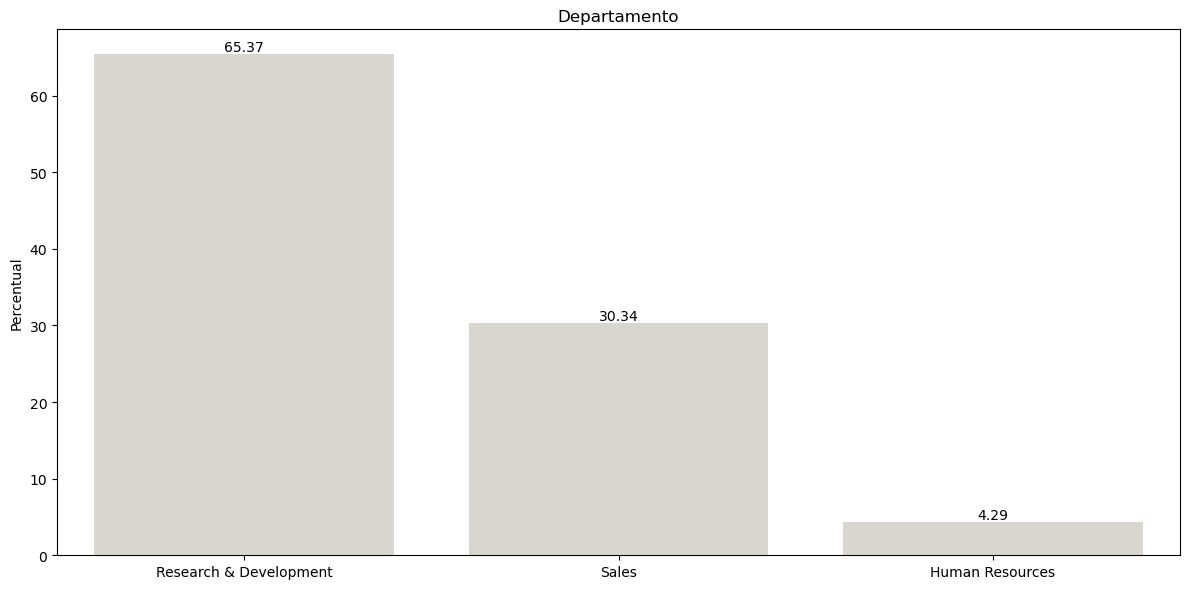

In [9]:
# Distribuição por 'department'
order = df['department'].value_counts().sort_values(ascending=False).to_frame().reset_index()
plt.subplots(figsize=(12, 6))
ax = sns.countplot(df, x='department', stat='percent', color='#dad7cd', order=order['department'])
ax.bar_label(container=ax.containers[0], fmt='%.2f')
ax.set_title('Departamento')
ax.set_xlabel('')
ax.set_ylabel('Percentual')
plt.tight_layout();

A proporção de funcionários pertencentes ao departamento de Research & Development representa a maioria da base de dados (65,37%), enquanto os funcionários de Sales representam 30,34% e o departamento de Human Resources representa apenas 4,29% da base.

Essa proporção realmente representa a distribuição de funcionários na empresa ou seria fruto da amostragem?

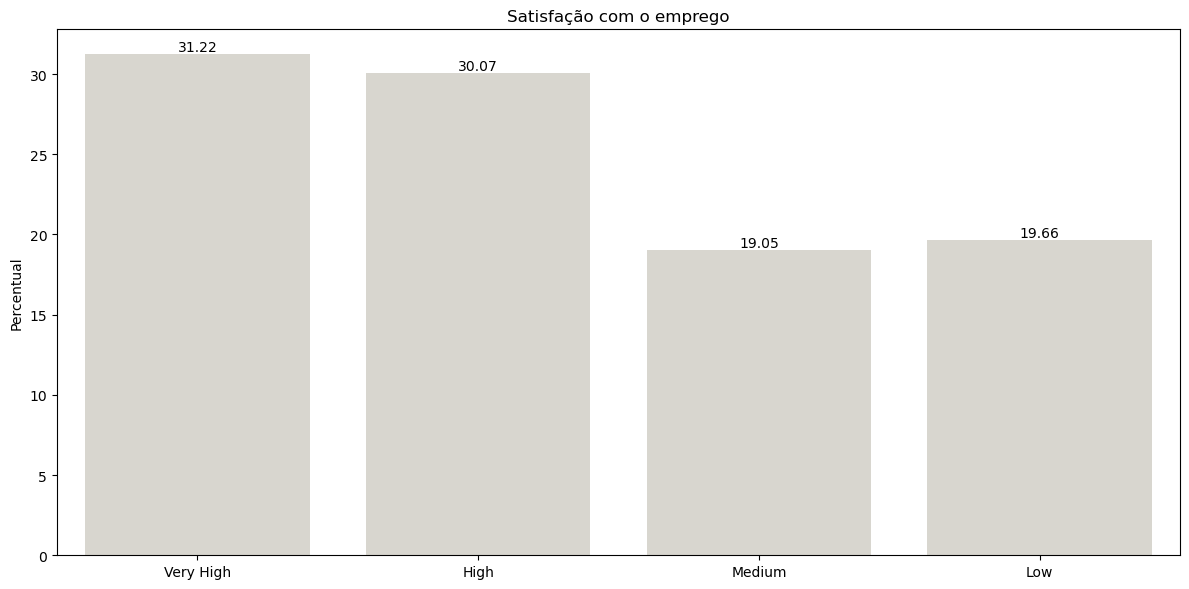

In [10]:
# Distribuição por 'job_satisfaction'
plt.subplots(figsize=(12, 6))
ax = sns.countplot(df, x='job_satisfaction', stat='percent', color='#dad7cd', order=['Very High', 'High', 'Medium', 'Low'])
ax.bar_label(container=ax.containers[0], fmt='%.2f')
ax.set_title('Satisfação com o emprego')
ax.set_xlabel('')
ax.set_ylabel('Percentual')
plt.tight_layout();

A maioria dos funcionários da base de dados têm satisfação muito alta (31,22%) e alta (30,07%) com a empresa. Cerca de 19,05% têm satisfação média e 19,66% têm baixa satisfação com a empresa.

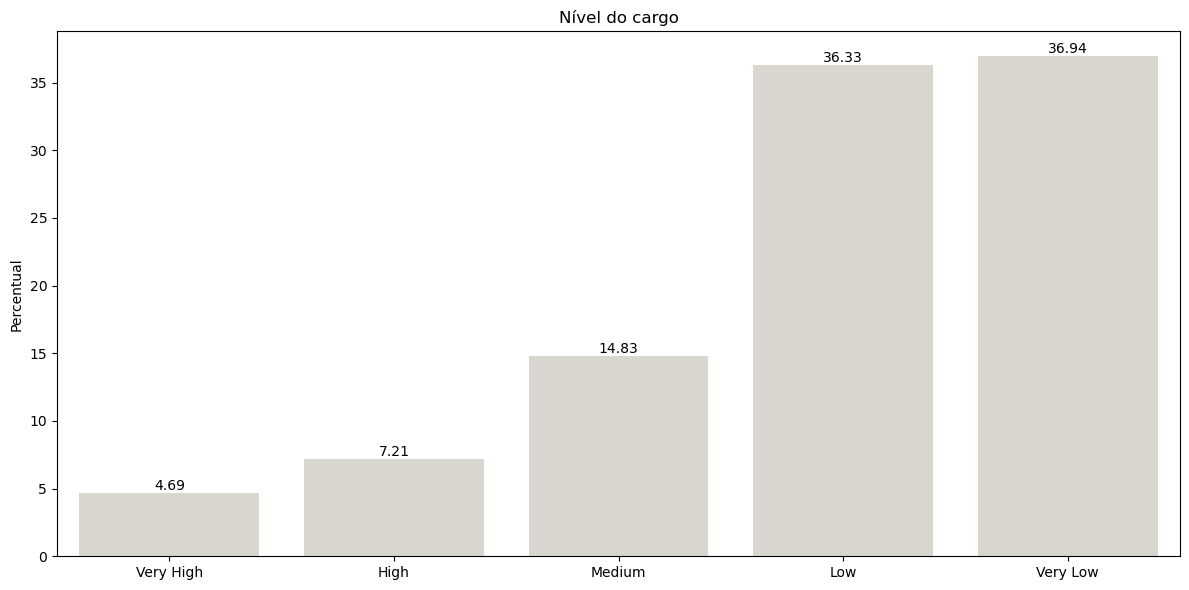

In [11]:
# Distribuição por 'job_level'
plt.subplots(figsize=(12, 6))
ax = sns.countplot(df, x='job_level', stat='percent', color='#dad7cd', order=['Very High', 'High', 'Medium', 'Low', 'Very Low'])
ax.bar_label(container=ax.containers[0], fmt='%.2f')
ax.set_title('Nível do cargo')
ax.set_xlabel('')
ax.set_ylabel('Percentual')
plt.tight_layout();

A grande maioria dos funcionários possue cargos de nível muito baixo (36,94%) e baixo (36,33%). 14,83% possuem cargos de nível médio. Uma minoria possui cargos de nível alto (7,21%) e muito alto (4,69%).

A distribuição de cargos na base de dados é condizente com a realidade de empresas no geral, nas quais um número menor de funcionários ocupa os cargos mais altos.

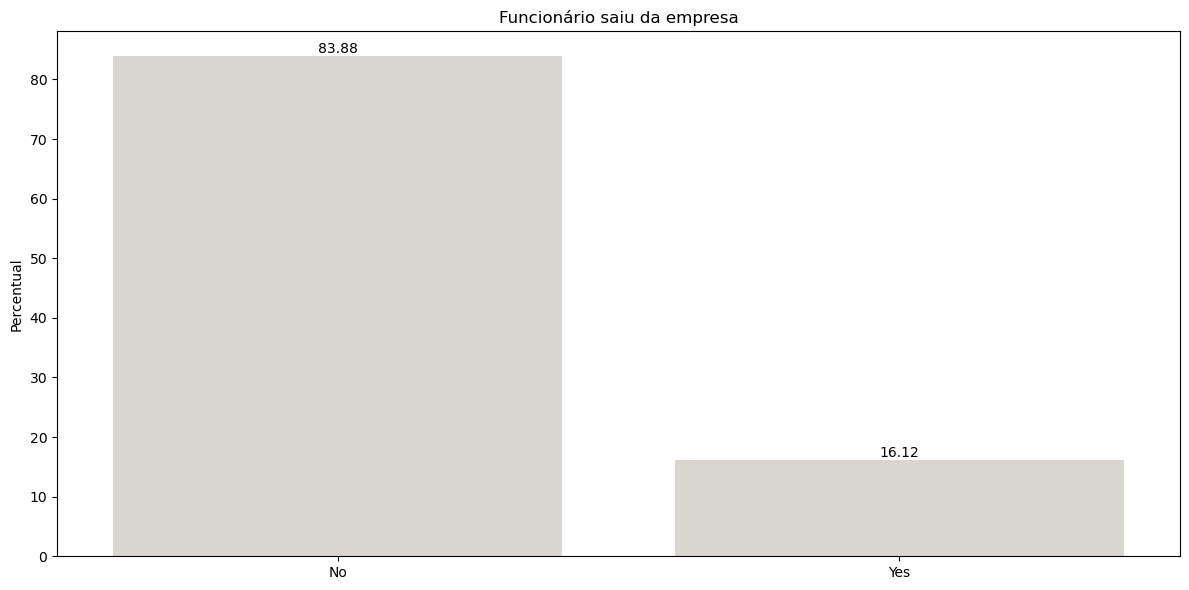

In [12]:
# Distribuição por 'attrition'
order = df['attrition'].value_counts(ascending=False).to_frame().reset_index()
plt.subplots(figsize=(12, 6))
ax = sns.countplot(df, x='attrition', stat='percent', color='#dad7cd', order=order['attrition'])
ax.bar_label(container=ax.containers[0], fmt='%.2f')
ax.set_title('Funcionário saiu da empresa')
ax.set_xlabel('')
ax.set_ylabel('Percentual')
plt.tight_layout();

A minoria dos funcionários (16,12%) saiu da empresa durante o período de abrangência da base de dados.

In [13]:
df.describe()

,years_at_company
count,1470.000000
mean,7.008163
std,6.126525
min,0.000000
25%,3.000000
50%,5.000000
75%,9.000000
max,40.000000


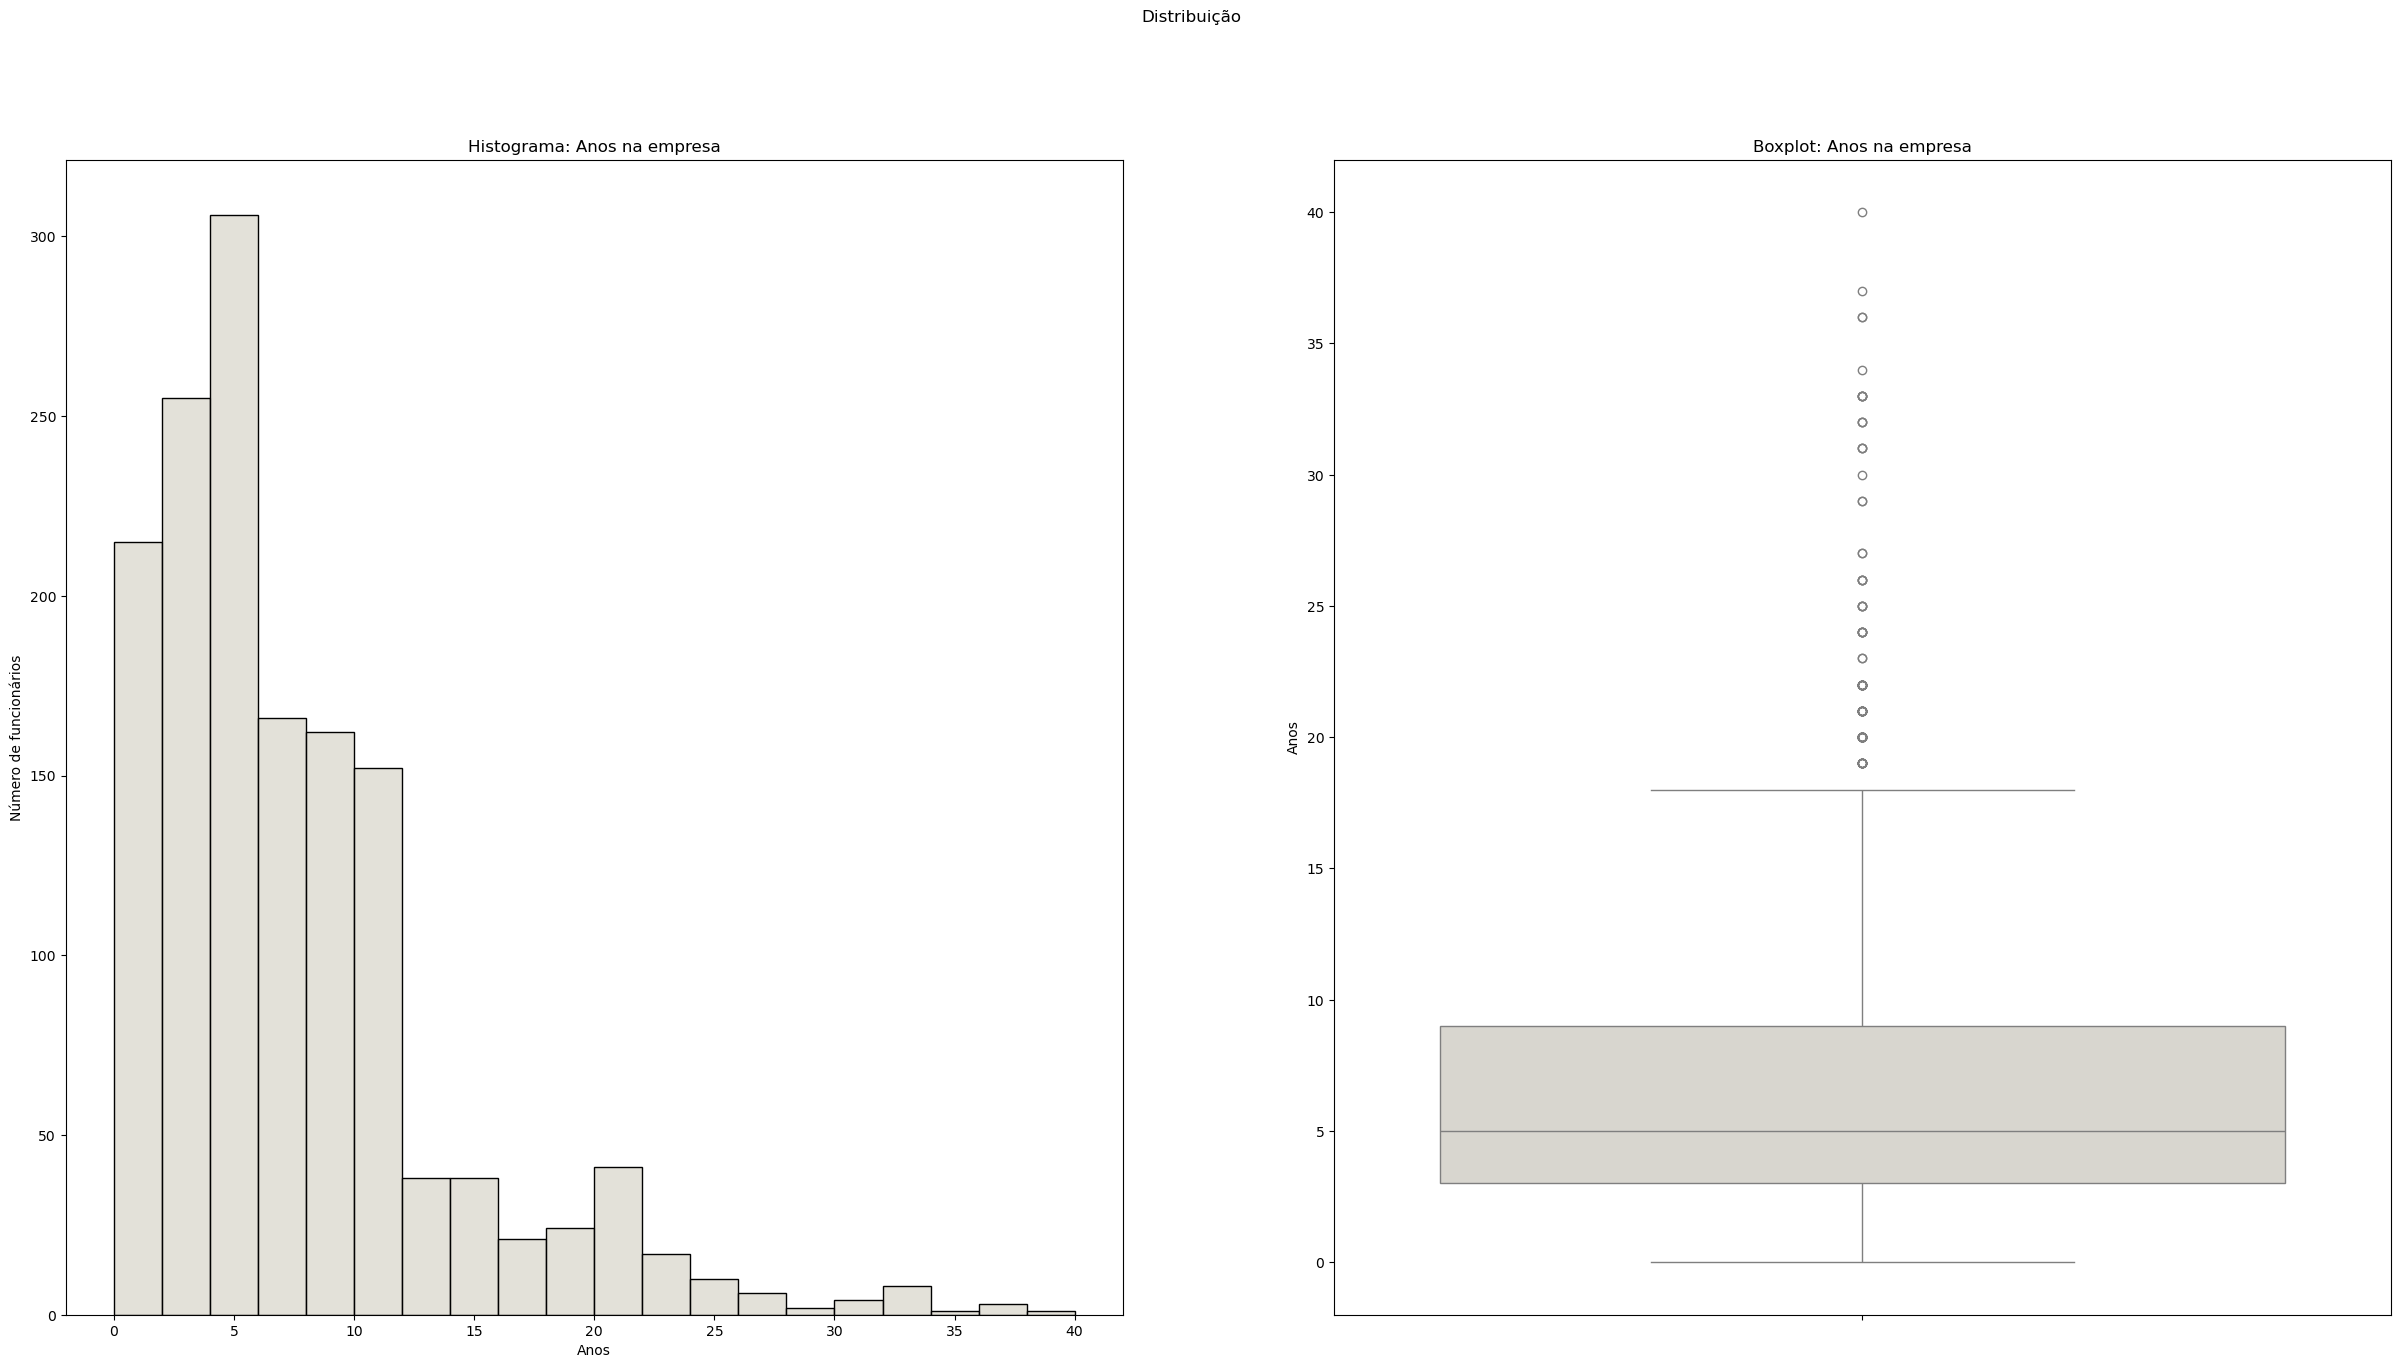

In [14]:
# Distribuição por 'years_at_company'

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Distribuição')

# Histograma
sns.histplot(ax=axes[0], data=df, x='years_at_company', bins=20, color='#dad7cd')
axes[0].set_title('Histograma: Anos na empresa')
axes[0].set_xlabel('Anos') 
axes[0].set_ylabel('Número de funcionários') 

# Boxlot
sns.boxplot(data=df['years_at_company'], color='#dad7cd')
axes[1].set_title('Boxplot: Anos na empresa')
axes[1].set_xlabel('') 
axes[1].set_ylabel('Anos');

In [15]:
print(f'Skew: {df['years_at_company'].skew():.2f} \nCurtose: {df['years_at_company'].kurtosis():.2f}')

Skew: 1.76 
Curtose: 3.94


A distribuição do tempo de permanência da empresa em anos apresenta cauda longa à direita (distribuição negativa). 50% dos funcionários está há até 5 anos na empresa e 75% está há até 9 anos, enquanto alguns poucos possuem elevado tempo de permanência na empresa (permanência máxima registrada de 40 anos). Dessa forma, o boxplot indica outliers (registros acima do limite superior de 18 anos).

Essa distribuição parece compatível com uma empresa de tecnologia, onde alguns funcionários permanecem por muito tempo, mas a maioria possui maior rotatividade.

## Emploração multivariada

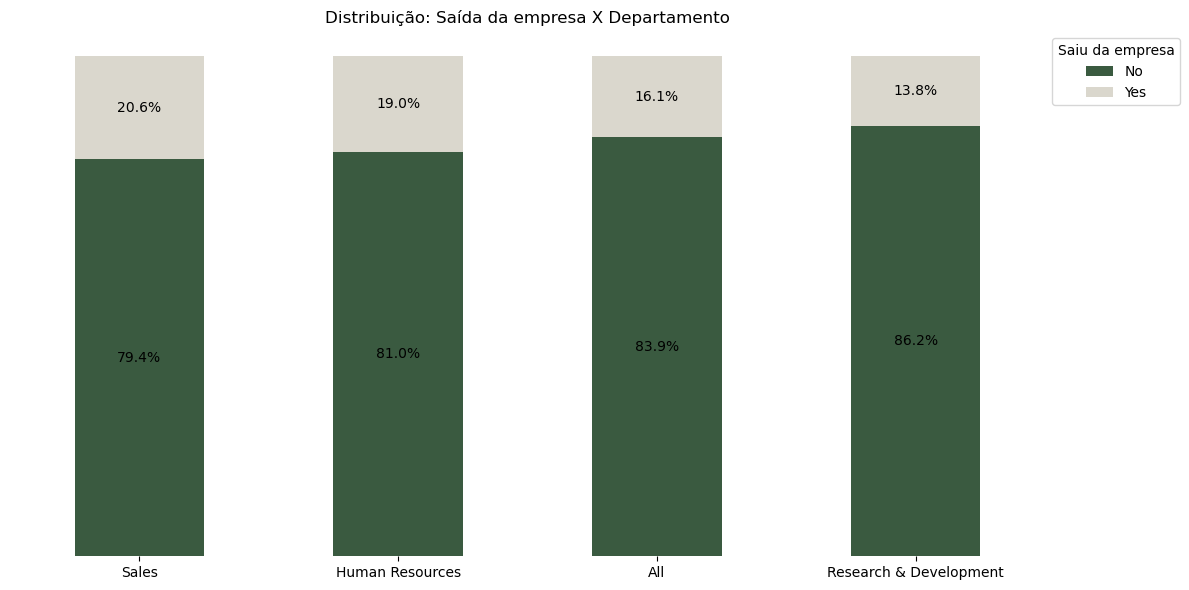

In [16]:
crosstab = pd.crosstab(df['department'], df['attrition'], normalize='index', margins=True)*100

fig, ax = plt.subplots(figsize=(12, 6))

crosstab.sort_values('Yes', ascending=False).plot(kind='bar', stacked=True, ax=ax, color=['#3a5a40', '#dad7cd'])

# Adicionar labels
for c in ax.containers:
    labels=[str(round(v.get_height(), 1)) + '%' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, label_type='center', labels=labels, size=10)

# Remover spines
for s in ['top', 'bottom', 'right', 'left']:
    ax.spines[s].set_visible(False)

plt.title('Distribuição: Saída da empresa X Departamento')
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=0)
plt.yticks([])
plt.legend(title='Saiu da empresa', bbox_to_anchor=(1, 1))
plt.tight_layout();

O departamento de Research & Development, apesar de ser o com mais funcionários, apresenta o menor percentual de saída da empresa (13,8%). O percentual de saída nos departamentos de Human Resources (19,0%) e Sales (20,6%) é semelhante.

O percentual de saída no departamento de Research & Development é menor que o percentual geral de saída da empresa (16,1%), enquanto nos outros departamentos o percentual de saída é maior que o geral.

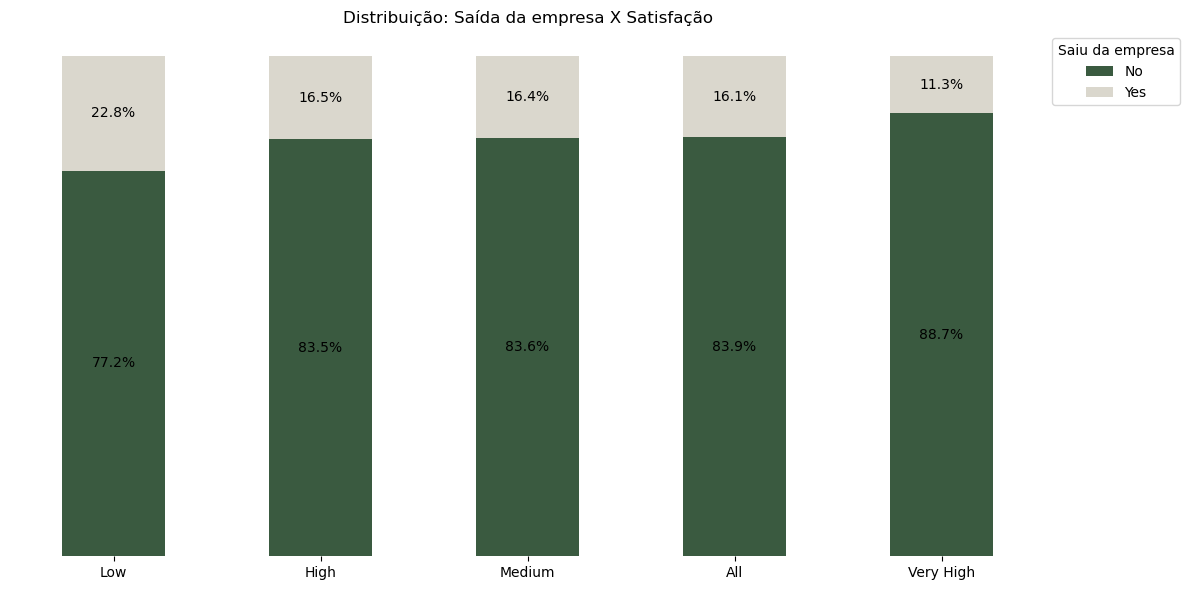

In [17]:
crosstab = pd.crosstab(df['job_satisfaction'], df['attrition'], normalize='index', margins=True)*100

fig, ax = plt.subplots(figsize=(12, 6))

crosstab.sort_values('Yes', ascending=False).plot(kind='bar', stacked=True, ax=ax, color=['#3a5a40', '#dad7cd'])

# Adicionar labels
for c in ax.containers:
    labels=[str(round(v.get_height(), 1)) + '%' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, label_type='center', labels=labels, size=10)

# Remover spines
for s in ['top', 'bottom', 'right', 'left']:
    ax.spines[s].set_visible(False)

plt.title('Distribuição: Saída da empresa X Satisfação')
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=0)
plt.yticks([])
plt.legend(title='Saiu da empresa', bbox_to_anchor=(1, 1))
plt.tight_layout();

Os funcionários com maior percentual de saída da empresa são os com baixa satisfação (22,8%). Esse resultado é esperado, pois um funcionário insatisfeito provavelmente irá buscar novas oportunidades. Os percentuais de saída dos funcionários com alta e média satisfação são próximos entre si (16,5% e 16,4%, respectivamente) e próximos do percentual geral de saída da empresa (16,1%). O percentual de saída dos funcionários com alta satisfação é o segundo maior da empresa, o que pode indicar que estes funcionários, apesar de satisfeitos podem ter recebido boas ofertas em outras empresas e decidiram sair. Profissionais satisfeitos com o emprego tendem a produzir mais resultados e com maior qualidade, e profissionais com esse perfil podem acabar sendo disputados por outras empresas.

Conforme esperado, o percentual de saída dos funcionários com satisfação muito alta com a empresa é o mais baixo (11,3%), abaixo do percentual geral (16,1%). Funcionários com alta satisfação têm menos motivos para querer sair da empresa, mesmo quando recebem ofertas, pois as condições que eles têm dentro da empresa atual provavelmente são melhores que a oferta.

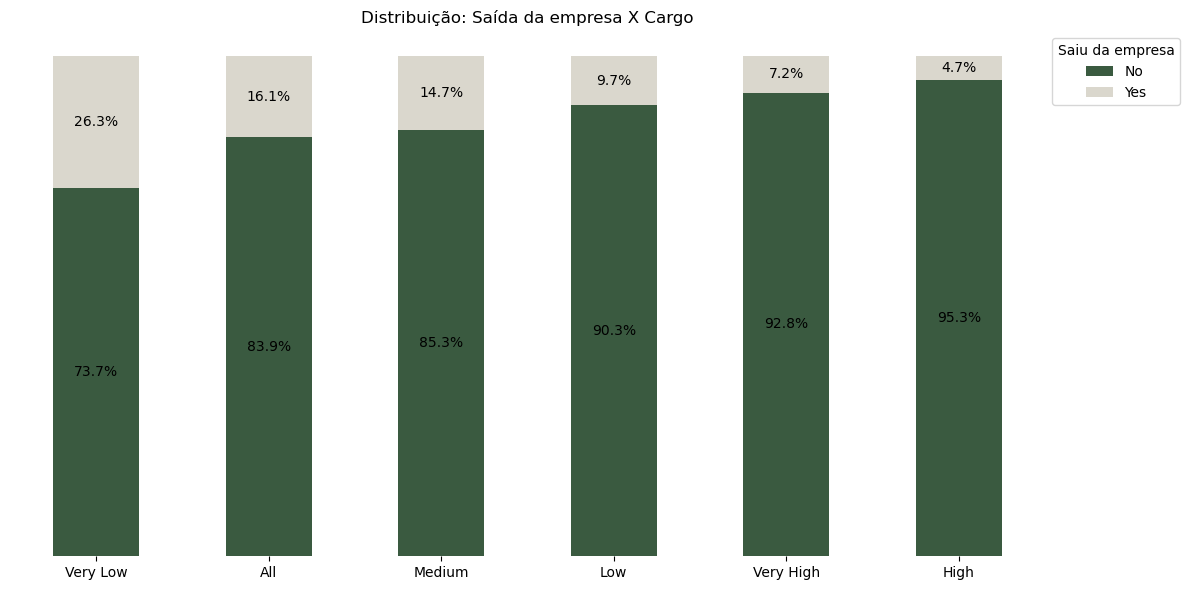

In [18]:
crosstab = pd.crosstab(df['job_level'], df['attrition'], normalize='index', margins=True)*100

fig, ax = plt.subplots(figsize=(12, 6))

crosstab.sort_values('Yes', ascending=False).plot(kind='bar', stacked=True, ax=ax, color=['#3a5a40', '#dad7cd'])

# Adicionar labels
for c in ax.containers:
    labels=[str(round(v.get_height(), 1)) + '%' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, label_type='center', labels=labels, size=10)

# Remover spines
for s in ['top', 'bottom', 'right', 'left']:
    ax.spines[s].set_visible(False)

plt.title('Distribuição: Saída da empresa X Cargo')
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=0)
plt.yticks([])
plt.legend(title='Saiu da empresa', bbox_to_anchor=(1, 1))
plt.tight_layout();

Os funcionários com cargos de nível Very Low têm o maior percentual de saída da empresa (26,3%), abaixo do percentual geral de 16,1%. Isso pode indicar que os funcionários de cargos iniciais não estejam vendo oportunidades de crescimento na empresa e optem por buscar outras oportunidades.
Os funcionários de nível médio possuem o segundo maior percentual de saída (14,7%), seguidos do de nível baixo (9,7%). Já os funcionários com cargos de nível muito alto e alto são os com o menor percentual de saída (7,2% e 4,7%, respectivamente). Isso é esperado, já que os profissionais de cargos mais elevados ganham melhor e, por isso, podem preferir continuar na empresa.

In [19]:
df.loc[:, ['years_at_company', 'attrition']].groupby('attrition', as_index=False).describe().transpose()

0         1
attrition                     No       Yes
years_at_company count    1233.0     237.0
                 mean   7.369019  5.130802
                 std    6.096298  5.949984
                 min         0.0       0.0
                 25%         3.0       1.0
                 50%         6.0       3.0
                 75%        10.0       7.0
                 max        37.0      40.0

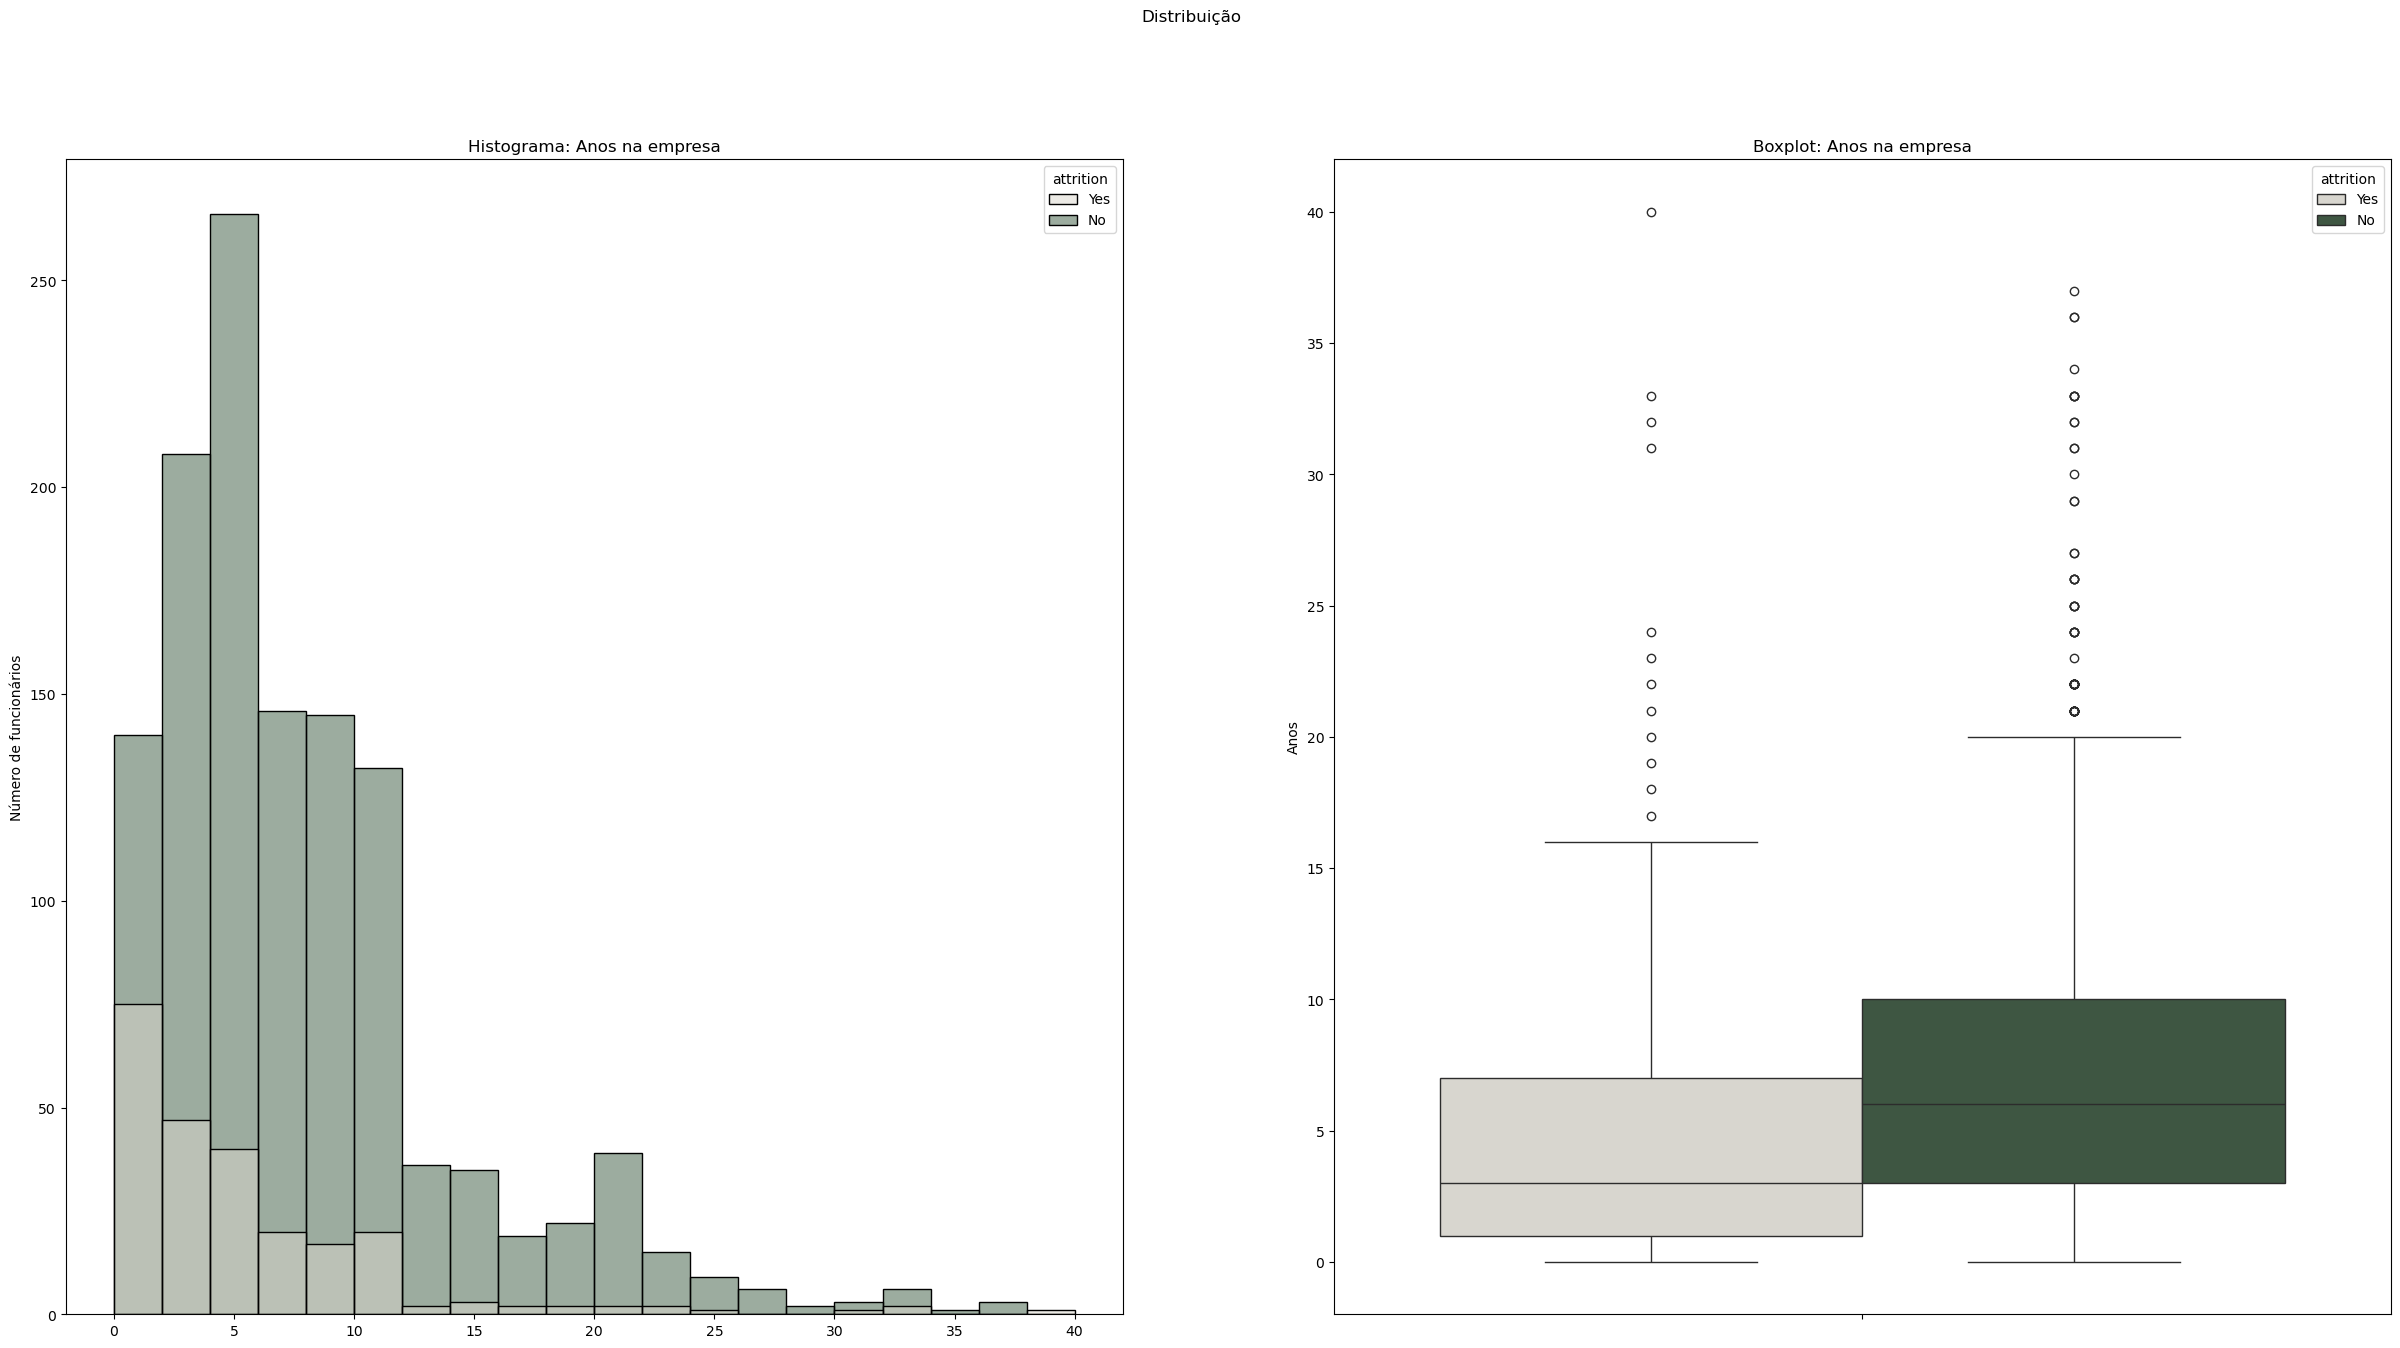

In [20]:
# Anos na empresa
fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Distribuição')

# Histograma
sns.histplot(ax=axes[0], data=df, x='years_at_company', hue='attrition', bins=20, palette=['#dad7cd', '#3a5a40'])
axes[0].set_title('Histograma: Anos na empresa')
axes[0].set_xlabel('') 
axes[0].set_ylabel('Número de funcionários')

# Boxplot
sns.boxplot(data=df, y='years_at_company', hue='attrition', palette=['#dad7cd', '#3a5a40'])
axes[1].set_title('Boxplot: Anos na empresa')
axes[1].set_xlabel('') 
axes[1].set_ylabel('Anos');

A média e mediana dos anos de permanência dos funcionários que ficaram na empresa é maior que a dos que saíram. Metade dos que saíram, o fizeram com até 3 anos de empresa, enquanto metade das pessoas que ficaram, já tem até 6 anos de empresa.

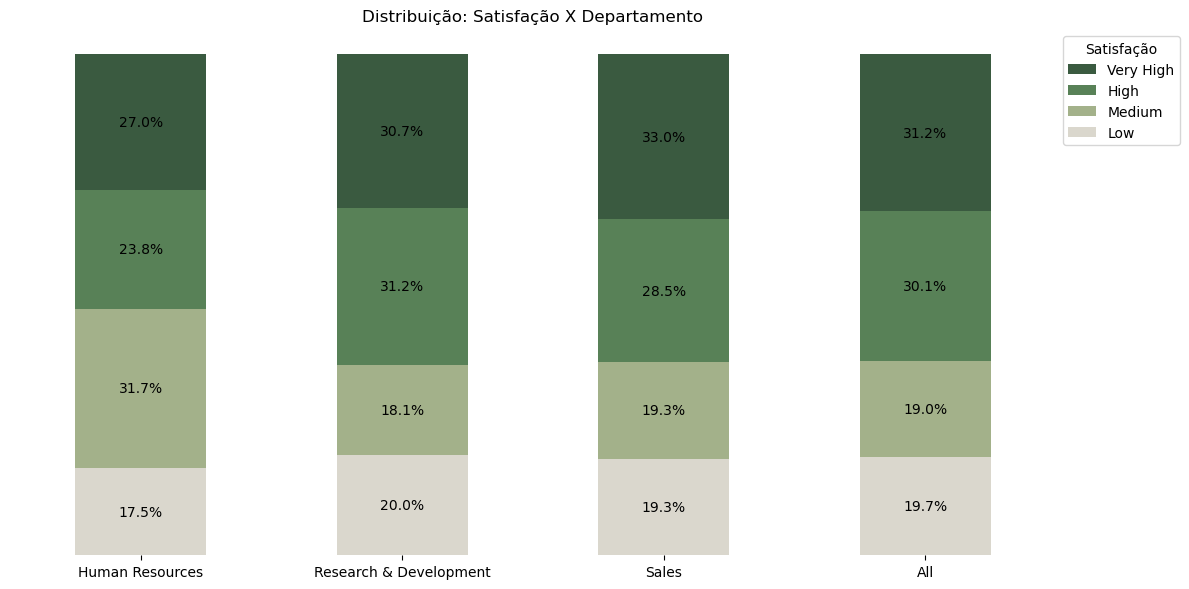

In [21]:
# Satisfação por departamento

crosstab = pd.crosstab(df['department'], df['job_satisfaction'], normalize='index', margins=True)*100

fig, ax = plt.subplots(figsize=(12, 6))

# Definindo as cores das barras
color = ['#dad7cd', '#a3b18a', '#588157', '#3a5a40']

crosstab[['Low', 'Medium', 'High', 'Very High']].plot(kind='bar', stacked=True, ax=ax, color=color)

# Adicionar labels
for c in ax.containers:
    labels=[str(round(v.get_height(), 1)) + '%' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, label_type='center', labels=labels, size=10)

# Remover spines
for s in ['top', 'bottom', 'right', 'left']:
    ax.spines[s].set_visible(False)

plt.title('Distribuição: Satisfação X Departamento')
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=0)
plt.yticks([])

# Ajustar ordem da legenda
handles, labels = ax.get_legend_handles_labels()
order = [3, 2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Satisfação',  bbox_to_anchor=(1, 1))

plt.tight_layout();

O departamento com maior percentual de baixa satisfação é o de Research & Development (20%), acima do percentual geral de baixa satisfação (19,7%). Apesar disso, o departamento de Research & Development, tem o menor percentual de saída entre os departamentos.

O departamento de Human Resources tem o maior percentual de satisfação média (31,7%). Em termos de satisfação, esse é o departamento mais insatisfeito.

O departamento com o maior percentual de alta satisfação é o Research & Development (31,2%), próximo do Sales (28,5%).

O departamento Sales tem o maior percentual de satisfação muito alta (33,0%), único departamento acima do percentual geral da empresa (31,2%). Apesar disso, esse é o departamento com maior percentual de saídas. O que pode indicar que as saídas neste departamento não estão necessariamente ligadas somente à satisfação. 

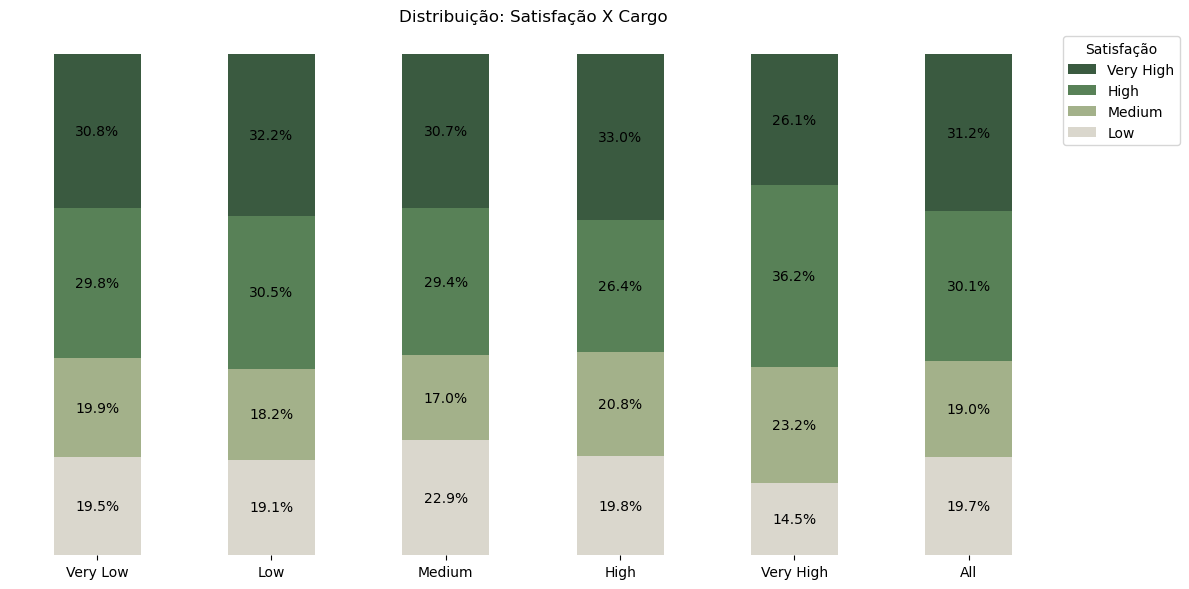

In [22]:
crosstab = pd.crosstab(df['job_level'], df['job_satisfaction'], normalize='index', margins=True)*100

fig, ax = plt.subplots(figsize=(12, 6))

# Definindo as cores das barras
color = ['#dad7cd', '#a3b18a', '#588157', '#3a5a40']

crosstab.loc[['Very Low', 'Low', 'Medium', 'High', 'Very High', 'All'],['Low', 'Medium', 'High', 'Very High']].plot(kind='bar', stacked=True, ax=ax, color=color)

# Adicionar labels
for c in ax.containers:
    labels=[str(round(v.get_height(), 1)) + '%' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, label_type='center', labels=labels, size=10)

# Remover spines
for s in ['top', 'bottom', 'right', 'left']:
    ax.spines[s].set_visible(False)

plt.title('Distribuição: Satisfação X Cargo')
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=0)
plt.yticks([])

# Ajustar ordem da legenda
handles, labels = ax.get_legend_handles_labels()
order = [3, 2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Satisfação',  bbox_to_anchor=(1, 1))

plt.tight_layout();

O percentual de satisfação baixo é semelhante entre os cargos de nível Very Low (19,5%), Low (19,1%) e High (19,8%). Os cargos de nível Medium têm o maior percentual de baixa saisfação (22,9%), acima do percentual geral da empresa (19,7%).

O maior percentual de média satisfação está entre os cargos de nível Very High (23,2%), acima do percentual geral da empresa (19,0%).

O maior percentual de alta satisfação está entre os cargos muito altos da empresa (36,2%). Os únicos cargos que têm o percentual de alta satisfação acima do percentual geral da empresa (30,1%) são os Very High e os Low.

Os cargos com maior percentual de satisfação muito alta são os High (33,0%) e Low (32,2%), únicos acima do percentual geral da empresa (31,2%).

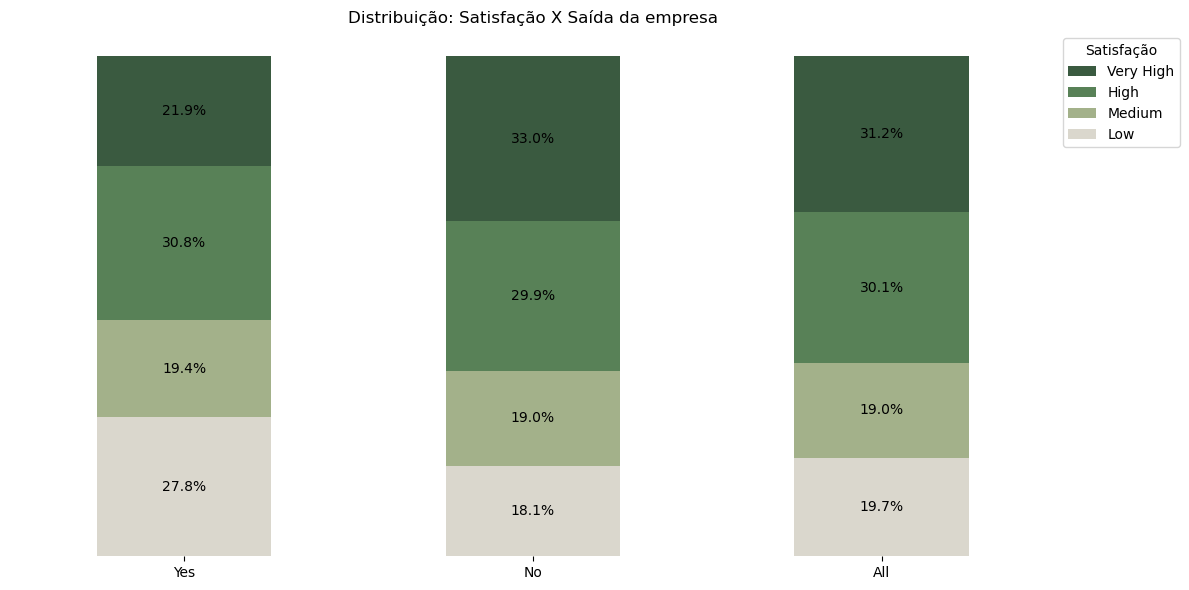

In [23]:
crosstab = pd.crosstab(df['attrition'], df['job_satisfaction'], normalize='index', margins=True)*100

fig, ax = plt.subplots(figsize=(12, 6))

# Definindo as cores das barras
color = ['#dad7cd', '#a3b18a', '#588157', '#3a5a40']

crosstab.loc[['Yes', 'No', 'All'],['Low', 'Medium', 'High', 'Very High']].plot(kind='bar', stacked=True, ax=ax, color=color)

# Adicionar labels
for c in ax.containers:
    labels=[str(round(v.get_height(), 1)) + '%' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, label_type='center', labels=labels, size=10)

# Remover spines
for s in ['top', 'bottom', 'right', 'left']:
    ax.spines[s].set_visible(False)

plt.title('Distribuição: Satisfação X Saída da empresa')
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=0)
plt.yticks([])

# Ajustar ordem da legenda
handles, labels = ax.get_legend_handles_labels()
order = [3, 2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Satisfação',  bbox_to_anchor=(1, 1))

plt.tight_layout();

A satisfação muito baixa com a empresa é maior entre o grupo de funcionários que saiu (27,8%), acima da proporção geral da empresa (19,7%). O percentual de satisfação muito alta é maior entre o grupo dos que ficaram na empresa (33,0%), acima do percentual geral (31,2%), contra apenas 21,9% do grupo que saiu.

Essa distribuição é esperada, pois espera-se que quem saiu estivesse menos satisfeito com a empresa do que quem ficou.

In [24]:
df.loc[:, ['years_at_company', 'job_satisfaction']].groupby('job_satisfaction', as_index=False).describe().transpose()

0         1         2          3
job_satisfaction            High       Low    Medium  Very High
years_at_company count     442.0     289.0     280.0      459.0
                 mean   7.004525  6.989619  7.107143   6.962963
                 std    6.180577  6.243599  6.312298   5.900257
                 min         0.0       0.0       0.0        0.0
                 25%         3.0       3.0       3.0        3.0
                 50%         5.0       5.0       5.0        5.0
                 75%        9.75       9.0       9.0       10.0
                 max        37.0      36.0      33.0       40.0

C:\Users\luisa\AppData\Local\Temp\ipykernel_15628\1486008234.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,


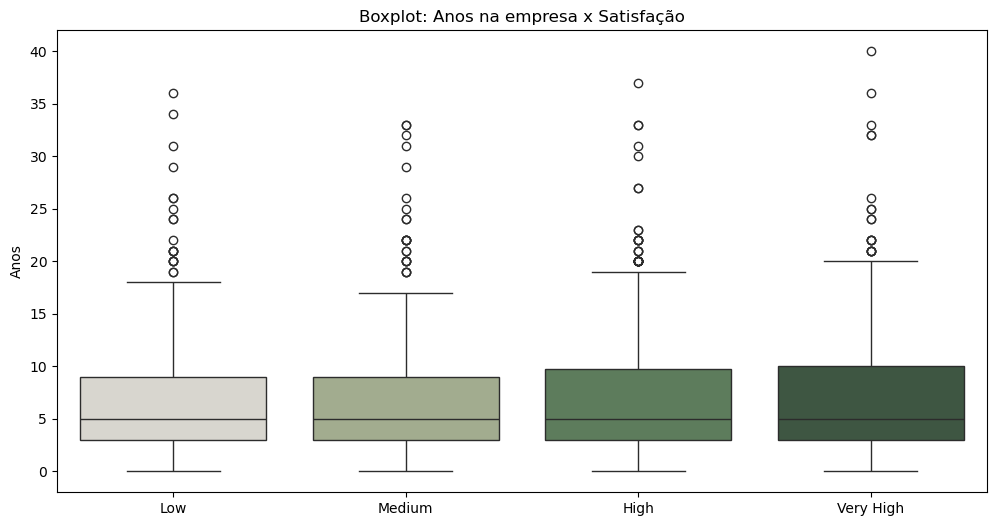

In [25]:
# Anos na empresa
fig, ax = plt.subplots(figsize=(12, 6))

# Boxplot
sns.boxplot(data=df, 
            y='years_at_company', 
            x='job_satisfaction',
            order=['Low', 'Medium', 'High', 'Very High'], 
            palette=['#dad7cd', '#a3b18a', '#588157', '#3a5a40']
            )

ax.set_title('Boxplot: Anos na empresa x Satisfação')
ax.set_xlabel('') 
ax.set_ylabel('Anos');

As distribuições de satisfação entre o tempo de permanência na empresa são semelhantes, não parece haver diferenciação significativa.

# Análise estatística

## Preparando dados

In [5]:
# Copiando dados
df2 = df_raw.copy()

# Selecionando colunas de interesse
df2 = df2[['Department', 'JobSatisfaction', 'JobLevel', 'YearsAtCompany', 'Attrition']]

# Colocando os nomes das colunas como lower snake case
df2.columns = (df2.columns
               .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
               .str.lower()
              )

## Considerações sobre tamanho amostral

O departamento de RH possui poucos colaboradores (apenas 63, enquando Research & Development possui 961 e Sales possui 446). Quando o tamanho amostral é menor, é preciso ter em mente que as métricas de satisfação e saída estão mais sujeitas a maiores variações (por exemplo, uma única saída ou avaliação ruim da empresa pode gerar um grande impacto nas métricas). Em times maiores, os indicadores tendem a ter maior estabilidade. Portanto, é preciso interpretar de forma crítica resultados envolvendo a variável departamento.

## Considerações sobre "p-hacking" e correção para múltiplos testes

Uma das causas do p-hacking é a realização de múltiplas análises a respeito de um mesmo fenômeno em um conjunto de dados, o que pode levar a um aumento da probabilidade de um falso positivo em um teste de hipóteses. Na presente análise, vamos realizar vários testes a respeito de dois fenômenos, a satisfação e a saída dos funcionários da empresa.

Para lidar com essa situação, existem algumas correções que podem ser realizadas para ajustar o nível de significância dos testes. Nesta análise, adotou-se a correção de Holm-Bonferroni, que ajusta o nível de significância de cada teste de forma sequencial. Esse método é menos conservador que Bonferroni, pois faz a distribuição da proteção contra erros do Tipo I ao longo dos testes, em vez de ser igualmente rigoroso para todos eles como Bonferroni.

## Existe associação entre o nível salarial e a intenção de sair da empresa?

Teste de hipóteses - Teste de associação

### Escolha do nível de significância

De acordo com a correção de Holm-Bonferroni (apresentada mais a frente), considerou-se o nível de significância alpha = 0.017.

### Definição das hipóteses

Hipótese nula: Não existe associação entre o nível salarial e a intenção de sair da empresa.

Hipótese alternativa: Existe associação entre o nível salarial e a intenção de sair da empresa.

### Verificação de pressupostos

Cada frequência esperada deve ser maior ou igual a 5.

### Escolha do teste

Teste Qui-Quadrado de independência para variáveis nominais com mais de uma categoria.

### Aplicando o teste

In [35]:
crosstab = pd.crosstab(df2['job_level'], df2['attrition'])
crosstab

attrition,No,Yes
job_level,,
1,400,143
2,482,52
3,186,32
4,101,5
5,64,5


In [36]:
statistic, p_value, dof, expected_freq = st.chi2_contingency(crosstab)

statistic, p_value, dof, expected_freq

(np.float64(72.5290131066739),
 np.float64(6.634684715458957e-15),
 4,
 array([[455.45510204,  87.54489796],
        [447.90612245,  86.09387755],
        [182.85306122,  35.14693878],
        [ 88.91020408,  17.08979592],
        [ 57.8755102 ,  11.1244898 ]]))

### Interpretação do teste

O p-valor é menor que alpha (6.634684715458957e-15 < 0.017), logo, há evidências estatísticas para rejeitar a hipótese nula. Ou seja, existe associação entre o nível salarial e a saída da empresa.

## Algum departamento tem maior risco de perda de talentos?

Teste de hipóteses - Teste de associação

### Escolha do nível de significância

De acordo com a correção de Holm-Bonferroni (apresentada mais a frente), considerou-se o nível de significância alpha = 0.017.

### Definição das hipóteses

Hipótese nula: Não existe associação entre o deparmento e a intenção de sair da empresa.

Hipótese alternativa: Existe associação entre o departamento e a intenção de sair da empresa.

### Verificação de pressupostos

Cada frequência esperada deve ser maior ou igual a 5.

### Escolha do teste

Teste Qui-Quadrado de independência para variáveis nominais com mais de uma categoria.

### Aplicando o teste

In [29]:
crosstab2 = pd.crosstab(df2['department'], df2['attrition'])
crosstab2

attrition,No,Yes
department,,
Human Resources,51,12
Research & Development,828,133
Sales,354,92


In [32]:
statistic, p_value, dof, expected_freq = st.chi2_contingency(crosstab2)

statistic, p_value, dof, expected_freq

(np.float64(10.79600732241067),
 np.float64(0.004525606574479633),
 2,
 array([[ 52.84285714,  10.15714286],
        [806.06326531, 154.93673469],
        [374.09387755,  71.90612245]]))

### Interpretação do teste

O p-valor é menor que alpha (0.005 < 0.017), logo, há evidências estatísticas para rejeitar a hipótese nula. Ou seja, existe associação entre o departamento e a intenção de sair da empresa.

## O padrão de satisfação difere entre quem ficou e quem saiu da empresa?

Teste de hipóteses - Tendência central de 2 amostras

### Escolha do nível de significância

De acordo com a correção de Holm-Bonferroni (apresentada mais a frente), considerou-se o nível de significância alpha = 0.017.

### Definição das hipóteses

H0: O padrão de satisfação é igual entre o grupo que saiu e o grupo que ficou na emrpesa.

H1: O padrão de satisfação é diferente entre o grupo que saiu e o grupo que ficou na empresa.

### Verificação de pressupostos

O teste t para a média de duas amostras independentes assume que os dados seguem a distribuição normal e que a variável dependente é contínua.

Nossos dados violam a premissa da variável dependente ser contínua, pois a satisfação é uma variável quantitativa ordinal (os dados estão organizados em níveis de satisfação que seguem uma escala de ordenação - nível 1 > nível 2 > nível 3, etc).

### Escolha do teste

Teste de Mann-Whitney.

O teste de Mann-Whitney é a alternativa não paramétrica ao teste t para duas amostras independentes. Ele pode ser usado em dados que estão em escala ordinal.

Esse teste calcula os postos entre conjuntos e analisa as diferenças entre eles para estabelecer se elas são estatisticamente significativas ou não.

### Aplicando o teste

In [22]:
# Preparando dados
left = df2[df2['attrition'] == 'Yes']['job_satisfaction'].dropna()
stayed = df2[df2['attrition'] == 'No']['job_satisfaction'].dropna()

In [23]:
statistic, p_value = st.mannwhitneyu(left, stayed, alternative='two-sided')

statistic, p_value

(np.float64(123362.5), np.float64(7.957917840891011e-05))

### Interpretação do teste

O p-valor é menor do que alpha (7.957917840891011e-05 < 0.017), logo, há evidências estatísticas para rejeitar a hipótese nula. Ou seja, o padrão de satisfação é diferente entre o grupo que saiu e o que ficou na empresa.

## Correção de Holm-Bonferroni para os testes envolvendo a saída dos funcionários

In [14]:
# Nível salarial e saída
p_value1 = 6.634684715458957e-15

# Departamento e saída
p_value2 = 0.004525606574479633

# Satisfação e saída
p_value3 = 7.957917840891011e-05

p_values = np.array([p_value1, p_value2, p_value3])

# Correção de Holm-Bonferroni
reject_holm, p_holm, _, _ = multipletests(p_values, alpha=0.05, method='holm')

reject_holm, p_holm, _, _ 

(array([ True,  True,  True]),
 array([1.99040541e-14, 4.52560657e-03, 1.59158357e-04]),
 0.016666666666666666,
 0.016666666666666666)

Todos os testes realizados acima são estatísticamente significativos após a correção.

## A satisfação difere entre departamentos?

Teste de hipóteses - Tendência central de 3 amostras

### Escolha do nível de significância

De acordo com a correção de Holm-Bonferroni (apresentada mais a frente), considerou-se o nível de significância alpha = 0.025.

### Definição das hipóteses

Hipótese nula: A satisfação é igual entre os departamentos.

Hipótese alternativa: Pelo menos um departamento possui distribuição de satisfação diferente.

### Verificação de pressupostos

A ANOVA é usada para comparar as variâncias entre as médias de grupos diferentes. Poderíamos usar a ANOVA 1 fator (verifica se um fator categórico corresponde a diferenças em uma variável contínua) caso seus pressupostos sejam atendidos. Ela possui as seguintes premissas:

- Amostras aleatórias
- Grupos independentes
- Variável dependente contínua
- Variável independente categórica
- Dados de amostra devem seguir uma distribuição normal ou cada grupo ter mais de 15 ou 20 observações.
- Os grupos devem ter variações aproximadamente iguais (caso contrário, usar ANOVA Welch).

Nossos dados violam a premissa da variável dependente ser contínua, pois a satisfação é uma variável quantitativa ordinal (os dados estão organizados em níveis de satisfação que seguem uma escala de ordenação - nível 1 > nível 2 > nível 3, etc).

### Escolha do teste

Teste de Kruskal-Wallis.

O teste de Kruskal-Wallis é a alternativa não paramétrica à ANOVA 1 fator. Ele pode ser utiliziado em dados que estão em escala ordinal.

### Aplicando o teste

In [9]:
# Preparando dados
human_resources = df2[df2['department'] == 'Human Resources']['job_satisfaction'].dropna()
research_development = df2[df2['department'] == 'Research & Development']['job_satisfaction'].dropna()
sales = df2[df2['department'] == 'Sales']['job_satisfaction'].dropna()

In [10]:
statistic, p_value = st.kruskal(human_resources, research_development, sales)

statistic, p_value

(np.float64(1.2124401184421472), np.float64(0.5454085897628997))

### Interpretação do teste

O p-valor é maior do que alpha (0.55 > 0.025), logo, não há evidências estatísticas para rejeitar a hipótese nula. Ou seja, o padrão de satisfação com a empresa é estatísticamente igual entre os departamentos.

## O tempo de casa influencia a satisfação?

Correlação entre duas variáveis.

### Escolha do nível de significância

De acordo com a correção de Holm-Bonferroni (apresentada mais a frente), considerou-se o nível de significância alpha = 0.025.

### Definição das hipóteses

H0: Não há correlação entre o tempo de casa (anos na empresa) e o nível de satisfação.

H1: Há correlação entre o tempo de casa (anos na empresa) e o nível de satisfação.

### Verificação de pressupostos

A variável satisfação segue uma escala ordinal.

### Escolha do teste

Teste de correlação de Spearman.

Esse teste não exige que as variáveis sigam uma distribuição normal e pode ser usado em dados discretos e ordinais, capturando associações monotônicas, mesmo não lineares.

### Aplicando o teste

In [33]:
rho, p_value = st.spearmanr(df2['years_at_company'], df2['job_satisfaction'])

rho, p_value

(np.float64(0.012280405536957233), np.float64(0.6380299281194943))

### Interpretação do teste

O p-valor é maior que alpha (0.638 > 0.025), logo, não há evidências estatísticas para rejeitar a hipótese nula. Ou seja, não há evidências de correlação entre o tempo de casa e satisfação com a empresa.

## Correção de Holm-Bonferroni para os testes envolvendo a satisfação dos funcionários

In [13]:
# Satisfação e departamento
p_value1 = 0.5454085897628997

# Satisfação e tempo de casa
p_value2 = 0.6380299281194943

p_values = np.array([p_value1, p_value2])

# Correção de Holm-Bonferroni
reject_holm, p_holm, _, _ = multipletests(p_values, alpha=0.05, method='holm')

reject_holm, p_holm, _, _ 

(array([False, False]), array([1., 1.]), 0.025, 0.025)

Os testes são estatísticamente não significativos (mesmo sem a aplicação da correção).

# Conclusões

A análise dos dados permitiu a detecção de padrões referentes aos funcionários que saíram da empresa e à satisfação. Com isso, foram recomendadas algumas ações para aumentar a retenção e satisfação dos colaboradores.

**Perfil geral da empresa:**
- **Distribuição dos funcionários:** O departamento com maior número de funcionários é o Research & Development. A distribuição de cargos diminui à medida que o nível do cargo aumenta, conforme o esperado em empresas. Metade dos funcionários estão ou estiveram na empresa por até 5 anos.
- **Satisfação:** De forma geral, a maioria dos funcionários possui satisfação alta ou muito alta com a empresa (> 60% dos funcionários).
- **Retenção de talentos:** A maioria dos funcionários (> 80%) permanece na empresa.

**Perda de talentos:**
- **Associação com o departamento:** O teste de associação qui-quadrado comprovou que existe associação entre o departamento e a saída da empresa. Os departamentos de Sales e Human Resources possuem os maiores percentuais de saída (6,8 e 5,2 pontos percentuais, respectivamente, acima do percentual de saída do departamento de Research & Development). 
- **Influência da satisfação:** O teste de Mann-Whitney comprovou que o padrão de satisfação de quem sai da empresa é diferente do que de quem fica. Funcionários com baixa satisfação saem mais.
- **Dificuldade de retenção nos cargos iniciais:** O teste de associação qui-quadrado comprovou que existe associação entre o nível do cargo (proxy para nível salarial) e a saída da empresa. Cargos de nível mais baixo possuem maiores percentuais de saída de funcionários (26,3%).
- **Tempo de casa:** Os que saíram ficaram, em média, menos tempo na empresa. Metade dos que saíram o fizeram com até 3 anos de empresa, enquanto metade dos que ficaram, já tem até 6 anos.

**Satisfação com a empresa:**
- **Satisfação por departamento:** O teste de Kruskal-Wallis comprovou não haver evidências estatísticas de que o padrão de satisfação é diferente entre departamentos. Sales tem o maior percentual de satisfação "muito alta" (33,0%), único departamento acima do percentual geral da empresa (31,2%). Apesar disso, possui o maior percentual de saídas, o que indica que há outras motivações para as saídas além da satisfação.
- **Satisfação por cargo:** Cargos de nível médio possuem maior percentual de baixa satisfação com a empresa. Os cargos que possuem maiores níveis de satisfação são os de nível baixo e muito alto.
- **Tempo de casa não incluencia:** O teste de correlação de Spearman comprovou não haver evidências estatísticas de correlação entre o tempo de permanência na empresa e a satisfação. 

**Recomendações:**

Além de ações gerais como o monitoramento contínuo dos níveis de satisfação e saída, e a implementação de canais anônimos de sugestões, elogios e reclamações, recomenda-se:

- **Analisar** formas de aumentar a satisfação de forma geral (em vez de ações focadas em departamentos específicos ou por tempo de permanência), pois a satisfação influencia a retenção de forma global e não há diferenças significativas entre departamentos ou correlação com o tempo de casa:

Ações sugeridas:

1. Realizar um diagnóstico do clima organizacional por meio de pesquisas internas para entender os fatores de insatisfação;
2. Avaliar processos internos como carga de trabalho, reconhecimento, oportunidades de crescimento e planos de carreira;
3. Estudar a implementação de programas de engajamento contínuos para todos;
4. Implementar pesquisas de pulso frequentes para capturar quedas de satisfação antes da saída.

- **Investigar** motivos que possam estar influenciando as saídas no departamento de Sales:

Ações sugeridas:

1. Analisar fatores além da satisfação, como metas agressivas, pressão por resultados, remuneração variável ou falta de suporte;
2. Avaliar ajuste de metas e incentivos;
3. Estudar a implementação de programas de suporte para lidar com estresse da área comercial.

- **Investigar** motivos que possam estar influenciando as saídas no departamento de Human Resources:

Ações sugeridas:

1. Analisar fatores além da satisfação, como cultura, carga de trabalho e liderança;
2. Avaliar ajuste de metas e incentivos.

- **Realizar** ações para aumentar a retenção de talentos em cargos iniciais:

Ações sugeridas incluem:

1. Implementar plano de carreira claro e programas de desenvolvimento desde o início;
2. Implementar processo de onboarding para que novos funcionários se sintam mais preparados;
3. Realizar acompanhamento por meio de check-ins regulares nos primeiros anos na empresa (período crítico de saída: primeiros 3 anos);
4. Revisar políticas salariais (incentivos, bônus ou reajustes).

As ações descritas acima são prioritárias e baseadas nos resultados da análise exploratória e estatística dos dados. São consideradas prioritárias devido à verificação das hipóteses por meio de testes estatísticos.

A seguir, sugere-se também ações não prioritárias baseadas na análise exploratória dos dados:

- **Realizar** ações para aumentar a satisfação de talentos em cargos de nível médio:

Ações sugeridas:

1. Verificar se há sobrecarga ou falta de reconhecimento;
2. Capacitar as lideranças intermediárias para melhor gestão das equipes e conflitos;
3. Oferecer feedbacks e reconhecimento contínuo aos profissionais de cargos intermediários.

- **Realizar** ações para aumentar o tempo de retenção dos funcionários na empresa:

Ações sugeridas:

1. Implementar programa de retenção focado em engajamento, desenvolvimento e cultura organizacional nos primeiros anos do funcionário na empresa;
2. Entender as expectativas dos novos funcionários em relação à empresa e avaliar o que deve ser alinhado à realidade e o que pode ser oferecido pela empresa aos funcionários.

A análise realizada permite que time de RH entenda os fatores que influenciam a saída e satisfação dos funcionários. Consequentemente, conduzindo o time à adoção de medidas mais acertadas e direcionadas aos fatores de fato associados à saída de funcionários e satisfação com a empresa. 